# Kernel Ridge Regression

!!! warning
    This example is under construction

Setup

In [1]:
using KernelFunctions
using MLDataUtils
using Zygote
using Flux
using Distributions, LinearAlgebra
using Plots

Flux.@functor SqExponentialKernel
Flux.@functor ScaleTransform
Flux.@functor KernelSum
Flux.@functor Matern32Kernel

Generate date

In [2]:
xmin = -3;
xmax = 3;
x = range(xmin, xmax; length=100)
x_test = range(xmin, xmax; length=300)
x, y = noisy_function(sinc, x; noise=0.1)
X = reshape(x, :, 1)
X_test = reshape(x_test, :, 1)

300×1 reshape(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, 300, 1) with eltype Float64:
 -3.0
 -2.979933110367893
 -2.959866220735786
 -2.939799331103679
 -2.919732441471572
 -2.899665551839465
 -2.879598662207358
 -2.859531772575251
 -2.839464882943144
 -2.819397993311037
  ⋮
  2.839464882943144
  2.859531772575251
  2.879598662207358
  2.899665551839465
  2.919732441471572
  2.939799331103679
  2.959866220735786
  2.979933110367893
  3.0

Set up kernel and regularisation parameter

In [3]:
k = SqExponentialKernel() + Matern32Kernel() ∘ ScaleTransform(2.0)
λ = [-1.0]

1-element Vector{Float64}:
 -1.0

In [4]:
function f(x, k, λ)
    return kernelmatrix(k, x, X; obsdim=1) *
           inv(kernelmatrix(k, X; obsdim=1) + exp(λ[1]) * I) *
           y
end
f(X, k, 1.0)

100-element Vector{Float64}:
 0.05182964061411741
 0.05919905939461147
 0.06765296346349857
 0.07661133988938658
 0.08496348297992953
 0.09206192977922086
 0.09700410110994603
 0.09876313430319734
 0.09730959234050154
 0.09273159524310515
 ⋮
 0.06362847249908504
 0.057728965667807323
 0.05007676575057891
 0.042385927789861874
 0.03642765130952892
 0.033028799465781605
 0.03154347752452612
 0.03110414238653152
 0.030575999512031868

In [5]:
loss(k, λ) = (ŷ -> sum(y - ŷ) / length(y) + exp(λ[1]) * norm(ŷ))(f(X, k, λ))
loss(k, λ)

1.5285537398503741

In [6]:
ps = Flux.params(k)
push!(ps, λ)
opt = Flux.Momentum(0.1)

plots = []
for i in 1:10
    grads = Zygote.gradient(() -> loss(k, λ), ps)
    Flux.Optimise.update!(opt, ps, grads)
    p = Plots.scatter(x, y; lab="data", title="Loss = $(loss(k,λ))")
    Plots.plot!(x_test, f(X_test, k, λ); lab="Prediction", lw=3.0)
    push!(plots, p)
end

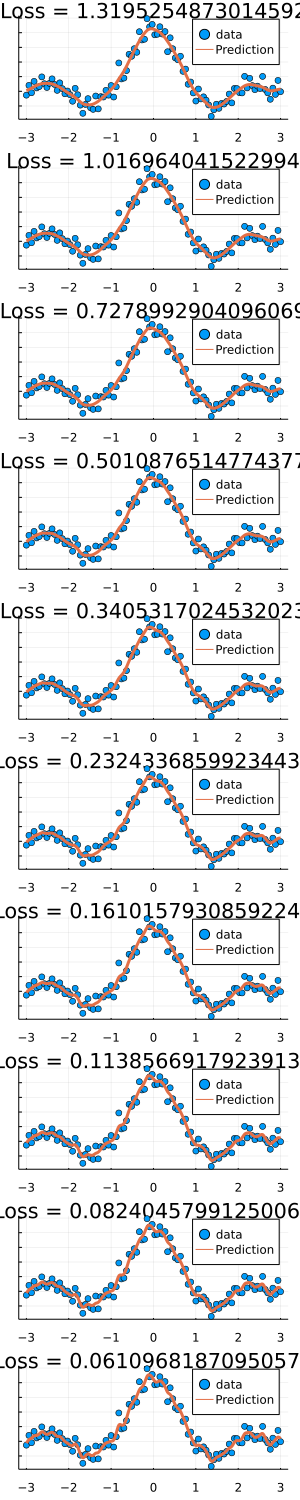

In [7]:
l = @layout grid(10, 1)
plot(plots...; layout=l, size=(300, 1500))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*